In [1]:
import import_ipynb
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

save_path = '../Data/'

with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [2]:
save_path = '../Data/'

with open(os.path.join(save_path, "train_data.pickle"), 'rb') as f:
    (train_data, train_range) = pickle.load(f)

with open(os.path.join(save_path, "val_data.pickle"), 'rb') as f:
    (val_data, val_range) = pickle.load(f)

rng = np.random.RandomState(seed=42)


def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = train_data
        categories = train_range
    else:
        X = val_data
        categories = val_range

    if len(X.shape) == 5:
        (n_classes, n_examples, w, h, s) = X.shape
    else:
        (n_classes, n_examples, w, h) = X.shape
        s = 1 

    indices = rng.randint(0, n_examples, size=(N,))
    if language is not None:  # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError(
                "This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low, high), size=(N,), replace=False)

    else:  # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes), size=(N,), replace=False)
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray(
        [X[true_category, ex1, :, :]]*N).reshape(N, w, h,s)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h,s)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(
        targets, test_image, support_set)
    pairs = [test_image, support_set]

    return pairs, targets

In [3]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h, w, scale = X.shape
    n = int(np.ceil(np.sqrt(nc)))
    img = np.zeros((n * h, n * w, scale))
    x = 0
    y = 0
    for example in range(nc):
        img[x * h:(x + 1) * h, y * w:(y + 1) * w, :] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [4]:
def plot_oneshot_task(pairs):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.imshow(pairs[0][0].reshape(105, 105, 3), cmap='gray')
    img = concat_images(pairs[1])
    ax1.axis('off')
    ax2.imshow(img, cmap='gray')
    ax2.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


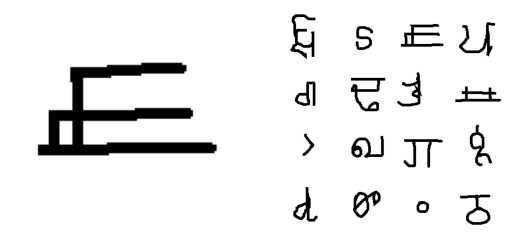

In [5]:
#Example of concat image visualization
pairs, targets = make_oneshot_task(16,"Malayalam")
plot_oneshot_task(pairs)

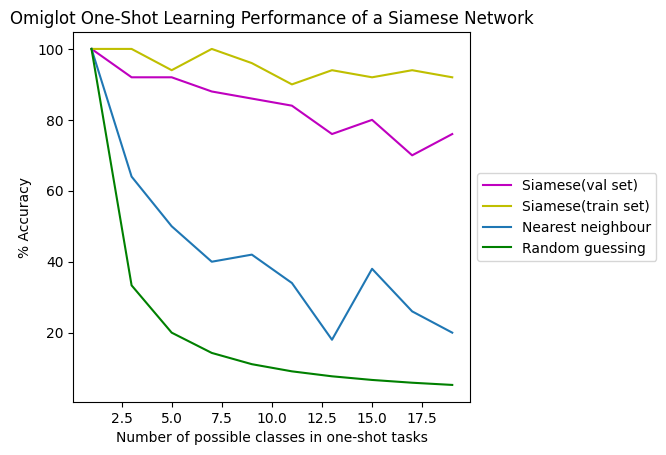

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


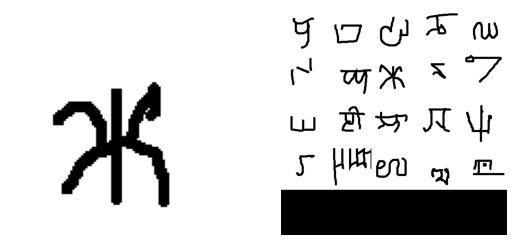

In [6]:
ways = np.arange(1,20,2)

fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, 'Oriya')
plt.show()

plot_oneshot_task(inputs)